# TensorFlow Tutorial #01

# 단순 선형 모델
by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/) / [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

이 튜토리얼을 텐서플로를 사용해 단순 선형 모델을 보여준다. 
MNIST 데이터셋을 불러온 후, 단순한 수치 모델을 정의하고 최적화한다. 
기본적인 선형 대수, 파이썬, 주피터 노트북에 익숙해야한다. 
또한 기계 학습이나 분류에 기본적인 지식이 있는 경우 도움된다.

## Import

In [1]:
# 노트북에서 matplotlib 를 이용해 그림 표시하게 해줌
%matplotlib inline 
import matplotlib.pyplot as plt # 그림 그리는 라이브러리
import tensorflow as tf # 텐서플로
import numpy as np # 다차원 배열을 사용하기 위한 넘파이
from sklearn.metrics import confusion_matrix # 혼동 행렬을 계산해주기 위한 함수

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [2]:
tf.__version__

'1.0.1'

## Load Data
MNIST 데이터셋은 약 12 MB 정도고, 주어진 경로에 없다면 자동으로 받아짐

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("./data/MNIST/", one_hot = True)

Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터셋은 70,000 장의 이미지와 라벨로 구성되어 있다. 
이 데이터셋은 상호 배타적인 3개로 나뉘어 있다. 
이 튜토리얼에서는 학습과 테스트만 사용할 것이다.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## One-Hot Encoding
이 데이터셋은 One-Hot encoding 으로 불러와진다. 
이것은 숫자가 해당 위치를 나타낸다. 
벡터의 i번째 위치만 1이고 나머지는 0이다.
예를 들어, 테스트셋에 첫 5개 이미지에 대한 One-Hot encoded 라벨이다.

In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

argmax 벡터 중 가장 높은 숫자의 인덱스를 찾는 함수를 이용해 다시 One-Hot encoding을 숫자로 바꿀 수 있다.

In [6]:
# data.test.labels 에서 하나씩 꺼내 label 이라고 부르고 그 label에서 가장 높은 숫자의 인덱스를 찾는 argmax() 함수를 사용해 다시 리스트로 만든다.
# 리스트 컴프리헨션
data.test.cls = np.array([label.argmax() for label in data.test.labels])

테스트셋에서 첫 5개 이미지에 대한 클래스를 볼 수 있다. 위의 One-Hot encoding과 비교하면, 인덱스 7만 1이고 나머지는 0인 첫 이미지의 클래스는 7이다. 

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

## Data dimensions
데이터 차원은 아래 보이는 소스코드 여러군데에서 사용된다. 

컴퓨터프로그래밍에서 일반적으로 사용할 모든 숫자를 입력하는 하드코딩 보다는 변수나 상수를 사용하는 것이 최선이다. 

이것은 그 숫자들은 하나의 위치에서만 바꾸는 것을 의미한다. 

이상적으로 이것들은 자료에서 얻어질 것이지만, 여기서는 숫자들로 입력한다.

In [8]:
# MNIST 이미지의 각 차원은 28 픽셀이다
img_size = 28

# 이미지들은 1차원 벡터로 저장되어 있다
img_size_flat = img_size * img_size

# 높이와 너비를 갖는 튜플은 reshape 배열에 사용된다.
img_shape = (img_size, img_size)

# 클래스의 숫자, 10개 숫자 각각이 하나의 클래스
num_classes = 10

## Helper-function for plotting images
3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수

In [9]:
# 3개의 인자를 받는다. (이미지, 실제 클래스값, 클래스 예측값)
def plot_images(images, cls_true, cls_pred=None):
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true) == 9
    
    # subplots로 3x3 격자 figure를 만듬
    fig, axes = plt.subplots(3, 3)
    # 각 격자의 떨어진 정도를 조정함
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 이미지를 각 순서대로 넣음
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # 실제값과 예측값을 보여줌
        # 예측 클래스 값들이 없으면
        if cls_pred is None:
            # 실제값만 나타냄
            xlabel = "True: {0}".format(cls_true[i])
        # 아니면
        else:
            # 둘다 나타냄
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        # x축 라벨 설정
        ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])

## Plot a few images to see if data is correct

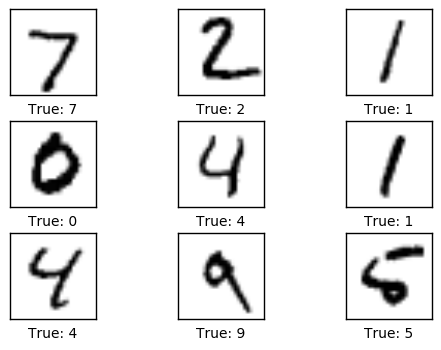

In [10]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = data.test.images[0:9]

# 이들 이미지의 실제 클래스값 얻음
cls_true = data.test.cls[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph
텐서플로의 목적은 파이썬에서 같은 연산을 실행하는 것보다 효율적으로 실행할 수 있는 계산 그래프(computational graph)를 갖는 것이다. 텐서플로는 넘파이가 매 순간 하나의 수식 연산만 아는 것과는 달리 실행될 때에 모든 계산 그래프를 알고 있어야하기 때문에 더 효율적이다.

텐서플로는 모델이 더 나은 성능을 내기 위해서 그래프의 변수들을 최적화하기 위해 필요한 그라디언트를 자동으로 계산할 수 있다. 이 그래프가 하나의 수식 연산의 결합이기 때문에 체인룰을 이용해 전체 그래프의 그라디언트를 계산할 수 있다.

텐서플로는 또한 멀티코어 CPU 이점도 있다.

텐서플로 그래프는 아래의 파트로 구성된다:
- Placeholder 변수는 그래프의 입력을 바꿀 때 사용
- Model 변수는 최적화될 변수
- 모델은 placeholder 변수와 model 변수들이 주어질 때 출력을 계산하는 수학 함수
- 비용은 변수의 최적화에 사용
- 최적화방법은 모델의 변수를 업데이트 하는 것

게다가, 텐서플로 그래프는 이 튜토리얼에서 다루지는 않지만, 텐서보드를 사용해 보기위한 로그를 남기기 위한 다양한 디버깅 스테이트먼트를 포함할 수 있다. 

## Placeholder variables
Placeholder 변수는 그래프를 실행할 때 바뀔 수도 있는 그래프에 입력값을 보낸다.
아래에서 시연한다.

첫째, 입력 이미지에 대한 placeholder 변수를 정의한다. 텐서 그래프에 입력으로 변할 수 잇는 이미지를 보낸다. 이것이 다차원 벡터 혹은 행렬을 의미하는 텐서다. 데이터 타입은 float32 이고 모양은 [None, img_size_flat] 이다. None 은 정해지지 않았음을 의미한다. 각 이미지는 항상 img_size_flat의 길이를 갖는다.


In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

다음으로 입력 이미지에 해당하는 실제 라벨의 placeholder를 만든다. 이 placeholder 변수의 모양은 [None, num_classes] 이다. None은 미정이고, num_classes 는 여기서는 10이다.

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

마지막으로, 각 이미지에 해당하는 클래스를 적어둔 라벨을 만든다. 정수

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables to be optimized
위에서 정의한 placeholder 변수와는 다르게, 몇몇 모델 변수들은 텐서플로에 의해서 변한다.

첫 변수는 weights 라고 불리는 최적화될 변수이다. [img_size_flat, num_classes]의 모양을 갖고, 0으로 초기화되어있다.

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

두번째 변수는 biases 라 불리는 1차원 변수이다.

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

## Model
이미지 x 와 weights 를 곱하고 biases 를 단순한 수학 연산이다.
이 결과는 [num_images, num_classes] 이다. 왜냐하면 이미지 x 가 [num_images, img_size_flat]의 모양을 갖고, weights 가 [img_size_flat, num_classes] 의 모양을 가지니, 두 행렬의 곱은 [num_images, num_classes]의 행렬이고, 여기에 biases 의 벡터가 각 행에 더해진다.
logits 은 텐서플로 전문용어, 다른 사람들은 다르게 부를 수도 있다.

In [16]:
logits = tf.matmul(x, weights) + biases

이제 logits 은 num_images의 행과 num_classes의 열을 갖는 행렬이다. i번째 행과 j번째 열은 i번째 입력이미지가 j번째 클래스일 가능성을 나타낸다.

하지만, 이들은 각 값들이 너무 작거나 크기 때문에 해석하기 어렵게 추정되어 있다. 그래서 이걸 각 행의 logits 합이 1이 되도록 정규화해주면, 각 요소는 0과 1 사이가 된다. 이것은 softmax 함수라 불리는 계산이고, 이 결과는 y_pred에 저장된다.

In [17]:
y_pred = tf.nn.softmax(logits)

이 예측된 클래스는 각 행의 가장 큰 요소의 인덱스를 얻는 것으로 y_pred로부터 구할 수 있다.

In [18]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost-function to be optimized
입력 이미지를 분류하는데에 더 나은 모델을 만들기 위해, 우리는 weights 와 biases를 바꿔야만 한다. 이를 위해 우리는 y_pred와 바람직한 실제 출력 y_true를 비교함으로써 현재 모델의 성능이 얼마인지 알아야할 필요가 있다.

크로스엔트로피는 분류에서의 성능 측정 지표이다. 크로스엔트로피는 항상 양의 값을 갖는 연속함수이고, 실제와 예측이 정확히 일치하면 0을 갖는다. 그러므로, 최적화의 목표는 weights와 biases 를 바꿔감으로써 가능한한 0에 가깝게 크로스엔트로피를 최소화하는 것이다.

텐서플로는 크로스엔트로피를 계산하기 위한 내장함수가 있다. 다만, 이것은 내부적으로 소프트맥스를 하기 때문에 logits을 사용해야한다.

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits,
                                                        labels = y_true)

이제 우리는 각 이미지에 대한 크로스엔트로피를 계산할 수 있다. 하지만, 크로스엔트로피를 최적화하는데 사용하기 위해서는 하나의 숫자가 되어야한다. 그래서 우리는 모든 이미지 분류에 대한 크로스엔트로피를 평균한다.

In [20]:
cost = tf.reduce_mean(cross_entropy)

## Optimiztation method
이제 비용 함수를 최소화해줄 최적화기(optimizer)를 만들 수 있다. 여기서는 step_size를 0.5로 설정한 기울기 강하(Gradient Descent) 의 기본형을 사용한다.

이 시점에서 최적화는 아무것도 수행되지 않는다. 사실, 아무것도 전혀 계산되지 않는다. 단지 나중에 실행될 최적화기 객체를 텐서플로 그래프에 더한 것 뿐이다.

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## Performance measures
사용자에게 진행사항을 나타내기 위한 성능 지표가 필요하다.
이미지의 예측 클래스 값이 실제 클래스 값과 일치하는지 아닌지에 대한 진리값(boolean) 벡터이다.

In [22]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

이건 분류 정확도를 계산한다. 이건 진리값 벡터기 때문에 float 형으로 바꿔서 False는 0으로 True는 1로 바꾼 후에 평균한다.

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run
## Create TensorFlow session
텐서플로 그래프를 만들면, 그래프를 실행하는데 사용되는 Session을 만들어야한다.

In [24]:
session = tf.Session()

## Initialize variables
weights 와 biases의 변수들은 최적화 전에 초기화되어야만 한다.

In [25]:
session.run(tf.global_variables_initializer())

## Helper-function to perform optimization iterations
학습 데이터셋에 5만개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

In [26]:
batch_size = 100

weights와 biases를 점진적으로 향상시키기 위한 최적화를 수행하는 함수. 각 반복에서, 데이터의 새로운 표본이 선택되고, 텐서플로는 그 학습 표본들을 사용해 최적화기를 실행한다.

In [27]:
# 반복횟수를 인자로 받는다
def optimize(num_iterations):
    # 반복횟수동안 반복
    for i in range(num_iterations):
        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        # y_true_cls placeholder 에 대해서는 설정하지 않는다. 왜냐하면 이것은 학습동안 사용되지 않기 때문이다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 학습 자료의 이 표본을 사용해 최적화기를 실행한다.
        # 텐서플로는 feed_dict_train에 있는 변수들을 placeholder 변수에 할당하고 실행한다.
        session.run(optimizer, feed_dict=feed_dict_train)

## Helper-functions to show performance
텐서플로 그래프에 입력으로 사용될 테스트셋 자료의 사전이다.  텐서플로 그래프에 placeholder 올바른 이름을 사용해야만 한다.

In [28]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

테스트셋에 대한 분류 정확도를 표시하는 함수

In [29]:
def print_accuracy():
    # accuracy 를 계산하기 위해 텐서플로를 사용한다.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # 정확도를 표시한다.
    print("Accuracy on test-set: {0:.1%}".format(acc))

scikit-learn 을 사용해 혼동 행렬을 표시하고, 출력하기 위한 함수

In [30]:
def print_confusion_matrix():
    # 테스트셋에 대한 실제 분류를 얻는다
    cls_true = data.test.cls
    
    # 테스트셋에 대한 예측 분류를 얻는다.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # sklearn을 이용해 혼동 행렬을 얻는다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 혼동행렬을 텍스트로써 출력한다.
    print(cm)

    # 이미지로서 혼동 행렬을 표시한다.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # 도표에 대해 다양한 조정을 한다.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [31]:
def plot_example_errors():
    # 각 이미지의 예측이 올바른 지와 예측 클래스값을 얻는다.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)
    
    # 올바르게 분류되지 않은 이미지를 얻는다
    images = data.test.images[incorrect]
    
    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[incorrect]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = data.test.cls[incorrect]
    
    # 9개의 이미지를 나타낸다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Helper-function to plot the model weights
weights를 나타내기 위한 함수. 모델이 인식하도록 학습된 10개 숫자에 대한 10개 이미지를 나타낸다.

In [32]:
def plot_weights():
    # 가중치를 얻는다
    w = session.run(weights)
    
    # 가중치의 가장 큰 값과 낮은 값을 구한다.
    # 이것은 이미지를 서로 비교할 수 있도록 색 강도를 조정하는데 사용된다.
    w_min = np.min(w)
    w_max = np.max(w)

    # 3x4 격자의 figure를 만들고 마지막 2개는 사용되지 않는다.
    fig, axes = plt.subplots(3, 4)
    # 격자 간격 조정
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 첫 10개 subplot만 사용됨
        if i<10:
            # i번째 숫자에 대한 가중치를 얻고 이를 이미지로 바꾼다.
            # w의 shape는 (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # 각 부분도표의 이름을 붙인다.
            ax.set_xlabel("Weights: {0}".format(i))

            # 이미지로 나타낸다
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # 눈금을 지운다
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization
테스트셋에 대한 정확도는 9.8%다. 모델은 초기화되고 최적화되지 않았다. 그래서 항상 예측이 0이다. 9.8% 정확도는 모두 0으로 예측했을 때의 일어난다.

In [33]:
print_accuracy()

Accuracy on test-set: 9.8%


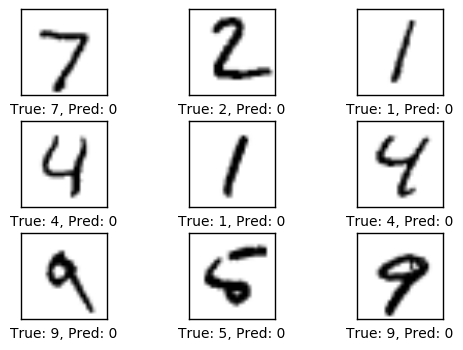

In [34]:
plot_example_errors()

## Performance after 1 optimization iteration
한번 최적화 반복 한 후에, 테스트셋에 대한 정확도는 40.7%로 올랐다. 이건 10개 이미지 중에 6개 정도 잘못 분류하는 것을 의미한다.

In [35]:
optimize(num_iterations=1)

In [36]:
print_accuracy()

Accuracy on test-set: 40.7%


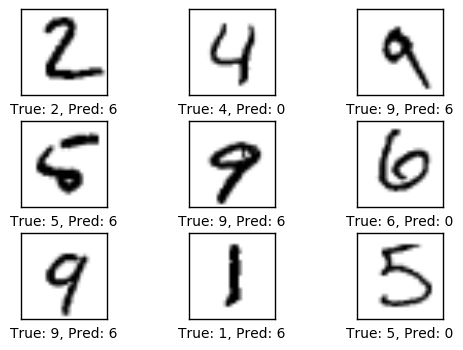

In [37]:
plot_example_errors()

가중치도 아래에 나타낼 수 있다. 양의 가중치는 빨간색이고 음의 가중치는 파란색이다. 이들 가중치는 이미지 필터로써 직관적으로 이해가능하다.

예를 들어, 이 가중치는 숫자 0의 이미지는 원의 양의 반응을 보이고, 원의 중앙은 음의 반응을 보이는지 결정하는데 사용된다.

유사하게, 1의 숫자를 나타내는 이미지는 이미지 가운데 수직선의 양의 반응을 보이고, 선 주위는 음의 반응을 보이는지에 사용된다.

가중치들은 주로 그들이 인식해야만 하는 숫자와 유사하다. 이것은 단지 100개의 이미지에 대해서만 최적화를 반복했기 때문이다. 수천개 이미지에 대해 학습한 후에는, 가중치는 더 해석하기 어렵다. 왜냐하면 각 숫자들이 다양하게 쓰여지는 것을 인식해야하기 때문이다.

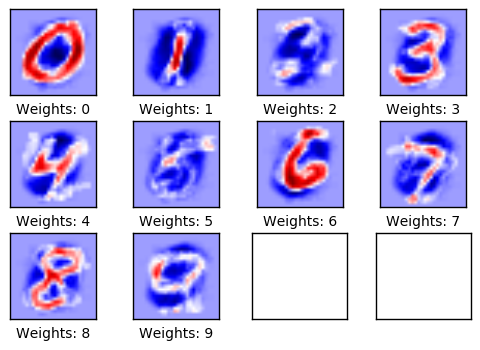

In [38]:
plot_weights()

## Performance after 10 optimization iterations

In [39]:
# 우리는 이미 한번 최적화했다.
optimize(num_iterations=9)

In [40]:
print_accuracy()

Accuracy on test-set: 78.2%


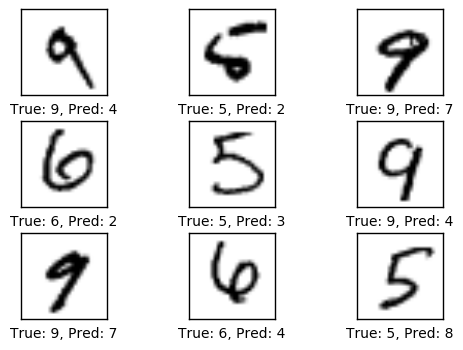

In [41]:
plot_example_errors()

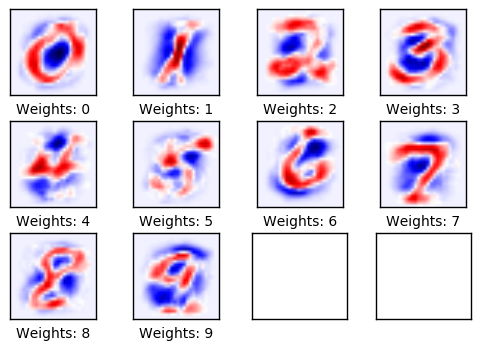

In [42]:
plot_weights()

## Performance after 1000 optimization iterations
1000 번 최적화 후에, 모델은 10번중 1번만 잘못 분류한다. 아래 보이는 것처럼, 잘못 분류된 것들은 사람도 분류하기 어렵다. 하지만 이 단순한 모델은 더 나은 성능을 내기 어렵기 때문에 더 복잡한 모델이 필요하다.

In [43]:
# 우리는 이미 10번 최적화했다.
optimize(num_iterations=990)

In [44]:
print_accuracy()

Accuracy on test-set: 92.0%


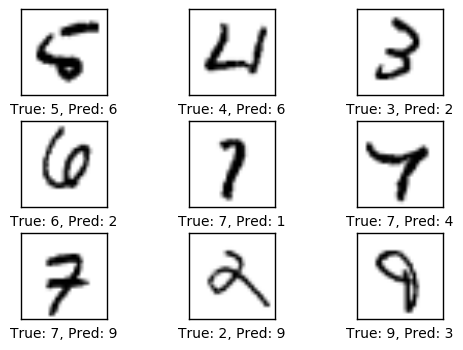

In [45]:
plot_example_errors()

이 모델은 매 반복마다 학습 데이터셋에 100개의 이미지를 사용해 1000번 학습이 되었다. 이미지의 수많은 다양성 때문에 가중치를 더 해석하기 어렵게 되었고, 모델이 선으로부터 구성된 숫자를 진짜 이해하는 것이닞, 단순히 수많은 픽셀 변화를 기억하는 것인지 의심할 수 있다.

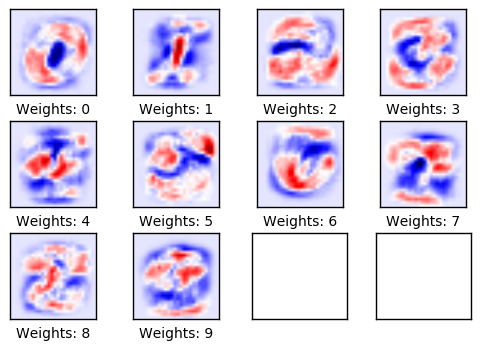

In [46]:
plot_weights()

오분류에 대해 더 자세히 보기 위해 혼동행렬이라 부르는 것을 보자.
예를 들어, 5의 이미지는 다른 모든 숫자에 대해 잘못 분류되었지만, 대부분은 3, 6, 8이다.

[[ 954    0    4    2    0    3   11    3    3    0]
 [   0 1106    4    1    0    1    4    2   17    0]
 [   6    5  946    6    8    1   14    8   34    4]
 [   3    1   41  890    0   23    3   10   26   13]
 [   1    3    6    1  895    0   16    2   11   47]
 [   9    3    8   38    8  752   19    6   42    7]
 [   9    3    6    0    9    7  917    2    5    0]
 [   2   11   36    4    6    1    0  929    2   37]
 [   4    4   11   11    8   19   13    8  891    5]
 [  10    6    3    8   23    7    0   20   16  916]]


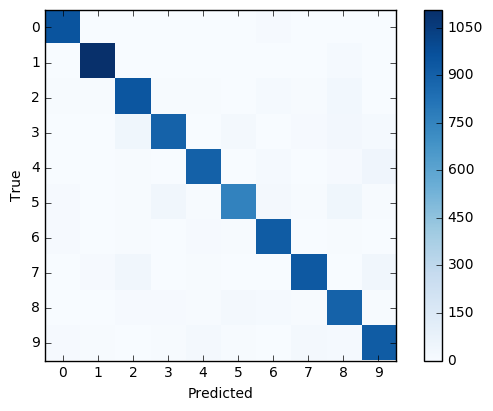

In [47]:
print_confusion_matrix()

## Exercises
텐서플로 스킬 올리는 데 도움될만한 것들.
제대로 사용하기 위해선 손으로 해보는 게 중요하다.

어느 것이라도 바꾸기 전에 백업할 수 있다.
- optimizer의 학습률 바꾸기
- optimizer 바꾸기 (AdagradOptimizer or AdamOptimizer)
- 배치 사이즈 바꾸기 (1 or 1000)
- 이러한 변화가 얼마나 성능에 영향을 미치는가?
- 이런 변화가 다른 분류 문제와 수치 모델에 같은 영향을 줄거라 생각하는가?
- 파라미터를 바꾸지 않고 노트북을 여러번 수행하면 같은 결과를 얻을 수 있는가? 왜 그런가?
- plot_example_errors() 함수를 잘못 분류된 이미지에 대해 logits과 y_pred 값을 표시하게 바꿔라
- softmax_cross_entropy_with_logits 대신에 sparse_softmax_cross_entropy_with_logits 사용하라. 소스코드에서 여러번 바꿔야할 수도 있다. 두 방법의 장점과 단점을 논의하라
- 이 소스코드 너무 많이 보지 말고 스스로 프로그램을 다시 만들어보라
- 프로그램이 어떻게 작동하는지 친구에게 설명하라

## License (MIT)
Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.